In [1]:
import sys
import numpy as np
import pandas as pd
from pathlib import Path

from calicost import arg_parse, parse_input, utils_IO, utils_hmm, utils_hmrf, utils_plotting, utils_phase_switch, hmrf

from matplotlib import pyplot as plt
import seaborn
import scanpy as sc
sc.set_figure_params(dpi=120)
import anndata
from sklearn.metrics import silhouette_score, adjusted_rand_score
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
plt.rcParams.update({'font.size': 14})

import warnings
from numba.core.errors import NumbaDeprecationWarning

## Configuration

In [2]:
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.filterwarnings("ignore", category=pd.errors.DtypeWarning)

In [3]:
pd.set_option('display.max_rows', 10)

In [4]:
! pwd

/Users/mw9568/Work/ragr/sim/utils


In [5]:
true_dir = "../simulated_data_related/"
calico_pure_dir = "../nomixing_calicost_related/"
numbat_dir = "../numbat_related/"
starch_dir = "../starch_related/"

# hg_table_file = "/nfs/turbo/umms-congma1/projects/CalicoST/GRCh38_resources/hgTables_hg38_gencode.txt"
hg_table_file = "/Users/mw9568/Work/ragr/CalicoST/GRCh38_resources/hgTables_hg38_gencode.txt"

# Clone identification accuracy

In [20]:
def get_best_r_hmrf(configuration_file, relative_path='../nomixing_calicost_related/'):
    """
    Retrieve the CalicoST random initialization with the maximum likelihood.
    """
    try:
        config = arg_parse.read_configuration_file(configuration_file)
    except:
        config = arg_parse.read_joint_configuration_file(configuration_file)
            
    # NB find the best HMRF initialization random seed
    df_3_clone = []
    
    for random_state in range(10):
        output_dir = relative_path + config['output_dir'].split('/')[-1]
        outdir = f"{output_dir}/clone{config['n_clones']}_rectangle{random_state}_w{config['spatial_weight']:.1f}"
        
        if Path(f"{outdir}/rdrbaf_final_nstates{config['n_states']}_smp.npz").exists():
            res_combine = dict(np.load(f"{outdir}/rdrbaf_final_nstates{config['n_states']}_smp.npz"), allow_pickle=True)
            df_3_clone.append( pd.DataFrame({"random seed":random_state, "log-likelihood":res_combine["total_llf"]}, index=[0]) )
            
    df_3_clone = pd.concat(df_3_clone, ignore_index=True)
    idx = np.argmax(df_3_clone["log-likelihood"])
    
    r_hmrf_initialization = df_3_clone["random seed"].iloc[idx]
    
    return int(r_hmrf_initialization)


def read_gene_loc(hg_table_file):
    """
    Read in (chronological order, start, end) table for (coding) gene definition.
    """
    df_hgtable = pd.read_csv(hg_table_file, sep='\t', header=0, index_col=0)
    
    # only keep chr1 to chr22
    df_hgtable = df_hgtable[df_hgtable.chrom.isin([f'chr{i}' for i in range(1, 23)])]
    
    # add chr column to be integer without "chr" prefix
    df_hgtable['chr'] = [int(x[3:]) for x in df_hgtable.chrom]
    
    # rename cdsStart and cdsEnd to start and end
    df_hgtable = df_hgtable.rename(columns={'cdsStart': 'start', 'cdsEnd': 'end'})

    # TODO rename name2 as gene.
    df_hgtable.set_index('name2', inplace=True)
    
    return df_hgtable[['chr', 'start', 'end']]


def read_true_gene_cna(df_hgtable, truth_cna_file):
    """
    Read true copy number aberrations    
    """
    true_gene_cna = df_hgtable.copy()
    df_cna = pd.read_csv(truth_cna_file, header=0, index_col=0, sep="\t")

    unique_clones = df_cna.index.unique()

    # print(f"Found unique clones: {unique_clones}")
    
    for clonename in unique_clones:
        clonal_cna = df_cna[df_cna.index == clonename]

        gene_status_str = np.array(['1|1'] * true_gene_cna.shape[0])
        
        # NB NEUTRAL == (1,1).
        gene_status_type = np.array(['NEU'] * true_gene_cna.shape[0], dtype='<U5')
        
        for i in range(clonal_cna.shape[0]):
            cna_str = f"{clonal_cna.A_copy.values[i]}|{clonal_cna.B_copy.values[i]}"
            
            if clonal_cna.A_copy.values[i] + clonal_cna.B_copy.values[i] > 2:
                cna_type = "AMP"
            elif clonal_cna.A_copy.values[i] + clonal_cna.B_copy.values[i] < 2:
                cna_type = "DEL"
            else:
                # TODO BUG (2,0) == CNLOH.
                cna_type = "CNLOH"
                
            is_affected = (true_gene_cna.chr == clonal_cna.chr.values[i])
            is_affected &= (true_gene_cna.end >= clonal_cna.start.values[i])
            is_affected &= (true_gene_cna.start <= clonal_cna.end.values[i])
            
            gene_status_str[is_affected] = cna_str
            gene_status_type[is_affected] = cna_type
            
        true_gene_cna[f'{clonename}_str'] = gene_status_str
        true_gene_cna[f'{clonename}_type'] = gene_status_type
    
    return true_gene_cna


def read_calico_gene_cna(configuration_file):
    """
    Read CalicoST estimated copy number aberrations.
    """
    r_calico = get_best_r_hmrf(configuration_file)
    
    tmpdir = "/".join( configuration_file.split("/")[:-1] )
    
    calico_gene_cna = pd.read_csv(f"{tmpdir}/clone3_rectangle{r_calico}_w1.0/cnv_genelevel.tsv", header=0, index_col=0, sep="\t")
    calico_clones = calico_gene_cna.columns[calico_gene_cna.columns.str.endswith('A')].str.split(" ").str[0]

    # print(f"Found CalicoST clones: {calico_clones}")
    
    for c in calico_clones:
        cna_type_assay = np.array(['NEU'] * calico_gene_cna.shape[0], dtype='<U5')
        
        cna_type_assay[ calico_gene_cna[f'{c} A'].values + calico_gene_cna[f'{c} B'].values < 2 ] = 'DEL'
        cna_type_assay[ calico_gene_cna[f'{c} A'].values + calico_gene_cna[f'{c} B'].values > 2 ] = 'AMP'

        is_cnloh = (calico_gene_cna[f'{c} A'].values + calico_gene_cna[f'{c} B'].values == 2) & (calico_gene_cna[f'{c} A'].values != calico_gene_cna[f'{c} B'].values)
        cna_type_assay[ is_cnloh ] = 'CNLOH'
        
        calico_gene_cna[f'{c}_type'] = cna_type_assay
    
    return calico_gene_cna


def read_numbat_gene_cna(bulk_clones_final_file):
    df_numbat = pd.read_csv(bulk_clones_final_file, header=0, sep="\t")
    df_numbat = df_numbat[['gene', 'sample', 'cnv_state']]
    
    n_numbat_samples = len( np.unique(df_numbat["sample"]) )
    
    # NB map numbat state to DEL, NEU, AMP, CNLOH
    mapper = {'del':'DEL', 'bdel':'DEL', 'neu':'NEU', 'amp':'AMP', 'bamp':'AMP', 'loh':'CNLOH'}
    df_numbat['cnv_state'] = df_numbat['cnv_state'].replace(mapper)
    
    # NB add "clone" prefix to numbat clone
    df_numbat['sample'] = 'clone_' + df_numbat['sample'].astype(str) + '_type'
    
    # NB reshape the table such that each row is a gene and each column is a clone
    numbat_gene_cna = pd.pivot_table(df_numbat, index='gene', columns='sample', values='cnv_state', aggfunc='first', fill_value='NEU')
    
    return numbat_gene_cna


def read_starch_gene_cna(states_file):
    starch_gene_cna = pd.read_csv(states_file, header=0, index_col=0, sep=",")

    # NB STARCH output is already a gene-by-clone matrix
    starch_gene_cna = starch_gene_cna.replace({0:'DEL', 1:'NEU', 2:'AMP'})
    starch_gene_cna.columns = 'clone_' + starch_gene_cna.columns + '_type'
    
    return starch_gene_cna

# TODO BUG null_value=0.0 -> null_value=np.nan
def compute_gene_F1(true_gene_cna, pred_gene_cna, null_value=0.0):
    """
    Compute the F1 score of CNA-affected gene prediction.

    Attributes
    ----------
    true_gene_cna : pd.DataFrame
        Each row is a gene with row index as gene name.  
        Contains columns <clone>_type to indicate whether each gene in NEU, DEL, AMP, CNLOH in each clone.
    """
    F1_dict = {}
    
    for event in ['DEL', 'AMP', 'CNLOH', 'overall']:        
        if event != 'overall':
            # NB unique set of gene names for a given CNA type, e.g. deletion.
            # TODO BUG type definition is not relative to truth.
            
            # NB evalues whether any of the available clones matches the event.
            pred_event_genes = set( pred_gene_cna.index[np.any(pred_gene_cna == event, axis=1)] )
            true_event_genes = set( true_gene_cna.index[np.any(true_gene_cna == event, axis=1)] )
        else:
            pred_columns = pred_gene_cna.columns[pred_gene_cna.columns.str.endswith('_type')]

            # TODO BUG usage of global calico_gene_cna. 
            # NB all genes that are not neutral.
            pred_event_genes = set(pred_gene_cna.index) - set( pred_gene_cna.index[np.all(pred_gene_cna[pred_columns] == 'NEU', axis=1)] )
            
            true_columns = true_gene_cna.columns[true_gene_cna.columns.str.endswith('_type')]
            true_event_genes = set(true_gene_cna.index) - set( true_gene_cna.index[np.all(true_gene_cna[true_columns] == 'NEU', axis=1)] )

        # NB some genes don't have enough coverage and are filtered out in preprocessing, so we remove them from true_event_genes.
        true_event_genes = true_event_genes & set(pred_gene_cna.index)
        
        if len(true_event_genes) == 0:
            F1_dict[event] = np.nan
        else:
            precision = len(pred_event_genes & true_event_genes) / len(pred_event_genes) if len(pred_event_genes) > 0 else null_value
            recall = len(pred_event_genes & true_event_genes) / len(true_event_genes) if len(true_event_genes) > 0 else null_value
            
            F1_dict[event] = 2. * precision* recall / (precision + recall) if precision + recall > 0 else null_value
        
    return F1_dict

In [7]:
def get_aris():
    map_cnasize = {
        "1e7":'10Mb', 
        "3e7":"30Mb", 
        "5e7":"50Mb"
    }

    df_clone_ari = []

    for n_cnas in [ (1,2), (3,3), (6,3) ]:
        for cna_size in ["1e7", "3e7", "5e7"]:
            for ploidy in [2]:
                for random in np.arange(10):
                    sampleid = f"numcnas{n_cnas[0]}.{n_cnas[1]}_cnasize{cna_size}_ploidy{ploidy}_random{random}"

                    true_path = f"{true_dir}/{sampleid}/truth_clone_labels.tsv"
                    true_clones = pd.read_csv(
                        true_path,
                        header=0,
                        index_col=0,
                        sep="\t"
                    )
                
                    true_clones = true_clones.rename(columns={true_clones.columns[0]: "true_label"})
    
                    # CalicoST
                    r_calico = get_best_r_hmrf(f"{calico_pure_dir}/{sampleid}/configfile0")

                    best_fit_clones_path = f"{calico_pure_dir}/{sampleid}/clone3_rectangle{r_calico}_w1.0/clone_labels.tsv"
                    calico_pure_clones = pd.read_csv(
                        best_fit_clones_path,
                        header=0,
                        index_col=0,
                        sep="\t"
                    )
                
                    calico_pure_clones = calico_pure_clones.join(true_clones)
    
                    df_clone_ari.append(
                        pd.DataFrame({
                            "cnas": f"{n_cnas[0], n_cnas[1]}",
                            "n_cnas": n_cnas[0] + n_cnas[1],
                            "cna_size": map_cnasize[cna_size],
                            "random": random,
                            "ploidy": int(ploidy),
                            "method": "CalicoST",
                            "ARI": adjusted_rand_score(calico_pure_clones.clone_label, calico_pure_clones.true_label),
                            "sample_id": sampleid,
                            "r_calico": r_calico,
                            "true_clones_path": true_path,
                            "best_fit_clones_path": best_fit_clones_path,
                        }, index=[0])
                    )
    
                    # Numbat
                    if Path(f"{numbat_dir}/{sampleid}/outs/clone_post_2.tsv").exists():
                        numbat_clones = pd.read_csv(f"{numbat_dir}/{sampleid}/outs/clone_post_2.tsv", header=0, index_col=0, sep="\t")
                        numbat_clones = numbat_clones.join(true_clones)
    
                        df_clone_ari.append(
                            pd.DataFrame({
                                "cnas": f"{n_cnas[0], n_cnas[1]}",
                                "n_cnas": n_cnas[0] + n_cnas[1],
                                "cna_size": map_cnasize[cna_size],
                                "random": random,
                                "ploidy": int(ploidy),
                                "method": "Numbat",
                                "ARI": adjusted_rand_score(numbat_clones.clone_opt, numbat_clones.true_label),
                                "sample_id": sampleid,
                                "true_clones_path": true_path,
                                "best_fit_clones_path": f"{numbat_dir}/{sampleid}/outs/clone_post_2.tsv"
                            }, index=[0])
                        )
                    else:
                        df_clone_ari.append(
                            pd.DataFrame({
                                "cnas": f"{n_cnas[0], n_cnas[1]}",
                                "n_cnas": n_cnas[0] + n_cnas[1],
                                "cna_size": map_cnasize[cna_size],
                                "random": random,
                                "ploidy": int(ploidy),
                                "method": "Numbat",
                                "ARI": 0.,
                                "sample_id": sampleid,
                                "true_clones_path": true_path,
                                "best_fit_clones_path": "-"
                            }, index=[0])
                        )
    
                    # STARCH
                    starch_clones = pd.read_csv(f"{starch_dir}/{sampleid}/labels_STITCH_output.csv", header=0, index_col=0, sep=",", names=["starch_label"])
                    map_index = {f"{true_clones.x.values[i]}.0x{true_clones.y.values[i]}.0":true_clones.index[i] for i in range(true_clones.shape[0])}
                    starch_clones.index = starch_clones.index.map(map_index)
                    starch_clones = starch_clones.join(true_clones)
    
                    df_clone_ari.append(
                        pd.DataFrame({
                            "cnas": f"{n_cnas[0], n_cnas[1]}",
                            "n_cnas": n_cnas[0] + n_cnas[1],
                            "cna_size": map_cnasize[cna_size],
                            "random": random,
                            "ploidy": int(ploidy),
                            "method": "STARCH",
                            "ARI": adjusted_rand_score(starch_clones.starch_label, starch_clones.true_label),
                            "sample_id": sampleid,
                            "true_clones_path": true_path,
                            "best_fit_clones_path": f"{starch_dir}/{sampleid}/labels_STITCH_output.csv"
                        }, index=[0])
                    )

    df_clone_ari = pd.concat(df_clone_ari, ignore_index=True).sort_values(by='cna_size', ascending=False)
    df_clone_ari.cna_size = pd.Categorical(df_clone_ari.cna_size, categories=['10Mb', '30Mb', '50Mb'], ordered=True)
    df_clone_ari.style.set_table_styles(
        [{
            'selector': 'th',
            'props': [('position', 'sticky'), ('top', '0')]
        }],
        overwrite=False
    ).set_sticky(axis="columns")

    return df_clone_ari

In [8]:
def plot_aris(df_clone_ari):
    fig, axes = plt.subplots(1, 3, figsize=(12,4), sharey=True, dpi=300)
    color_methods = ["#4963C1", "#97b085", "#dad67d"]

    for i, n_cnas in enumerate([3, 6, 9]):
        tmpdf = df_clone_ari[df_clone_ari.n_cnas == n_cnas]
    
        seaborn.boxplot(
            data=tmpdf,
            x='cna_size',
            y='ARI',
            hue='method',
            palette=seaborn.color_palette(color_methods),
            boxprops=dict(alpha=.7),
            linewidth=1,
            showfliers = False,
            ax=axes[i]
        )
        
        seaborn.stripplot(
            data=tmpdf,
            x='cna_size',
            y='ARI',
            hue='method',
            palette=seaborn.color_palette(color_methods),
            dodge=10,
            edgecolor="black",
            linewidth=0.5,
            ax=axes[i]
        )
    
        if (i + 1) < 3:
            axes[i].get_legend().remove()
        
        axes[i].set_ylabel("Clone ARI")
        axes[i].set_xlabel("Simulated CNA length")
        axes[i].set_title(f"{n_cnas} CNA events")

    h,l = axes[-1].get_legend_handles_labels()
    axes[-1].legend(h[:3], l[:3], loc="upper left", bbox_to_anchor=(1,1))

    fig.tight_layout()
    fig.show()

In [9]:
clone_aris = get_aris()
clone_aris

,cnas,n_cnas,cna_size,random,ploidy,method,ARI,sample_id,r_calico,true_clones_path,best_fit_clones_path
269,"(6, 3)",9,50Mb,9,2,STARCH,0.169663,numcnas6.3_cnasize5e7_ploidy2_random9,NaN,../simulated_data_related//numcnas6.3_cnasize5...,../starch_related//numcnas6.3_cnasize5e7_ploid...
60,"(1, 2)",3,50Mb,0,2,CalicoST,0.937367,numcnas1.2_cnasize5e7_ploidy2_random0,3.0,../simulated_data_related//numcnas1.2_cnasize5...,../nomixing_calicost_related//numcnas1.2_cnasi...
89,"(1, 2)",3,50Mb,9,2,STARCH,0.376744,numcnas1.2_cnasize5e7_ploidy2_random9,NaN,../simulated_data_related//numcnas1.2_cnasize5...,../starch_related//numcnas1.2_cnasize5e7_ploid...
88,"(1, 2)",3,50Mb,9,2,Numbat,0.467411,numcnas1.2_cnasize5e7_ploidy2_random9,NaN,../simulated_data_related//numcnas1.2_cnasize5...,../numbat_related//numcnas1.2_cnasize5e7_ploid...
87,"(1, 2)",3,50Mb,9,2,CalicoST,0.936623,numcnas1.2_cnasize5e7_ploidy2_random9,0.0,../simulated_data_related//numcnas1.2_cnasize5...,../nomixing_calicost_related//numcnas1.2_cnasi...
...,...,...,...,...,...,...,...,...,...,...,...
184,"(6, 3)",9,10Mb,1,2,Numbat,0.155721,numcnas6.3_cnasize1e7_ploidy2_random1,NaN,../simulated_data_related//numcnas6.3_cnasize1...,../numbat_related//numcnas6.3_cnasize1e7_ploid...
183,"(6, 3)",9,10Mb,1,2,CalicoST,0.808492,numcnas6.3_cnasize1e7_ploidy2_random1,3.0,../simulated_data_related//numcnas6.3_cnasize1...,../nomixing_calicost_related//numcnas6.3_cnasi...
182,"(6, 3)",9,10Mb,0,2,STARCH,0.614211,numcnas6.3_cnasize1e7_ploidy2_random0,NaN,../simulated_data_related//numcnas6.3_cnasize1...,../starch_related//numcnas6.3_cnasize1e7_ploid...
181,"(6, 3)",9,10Mb,0,2,Numbat,0.087400,numcnas6.3_cnasize1e7_ploidy2_random0,NaN,../simulated_data_related//numcnas6.3_cnasize1...,../numbat_related//numcnas6.3_cnasize1e7_ploid...


/var/folders/15/7gbpxlls5gjdc4w7hm4j0nhw0000gn/T/ipykernel_27045/1074084256.py:43: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


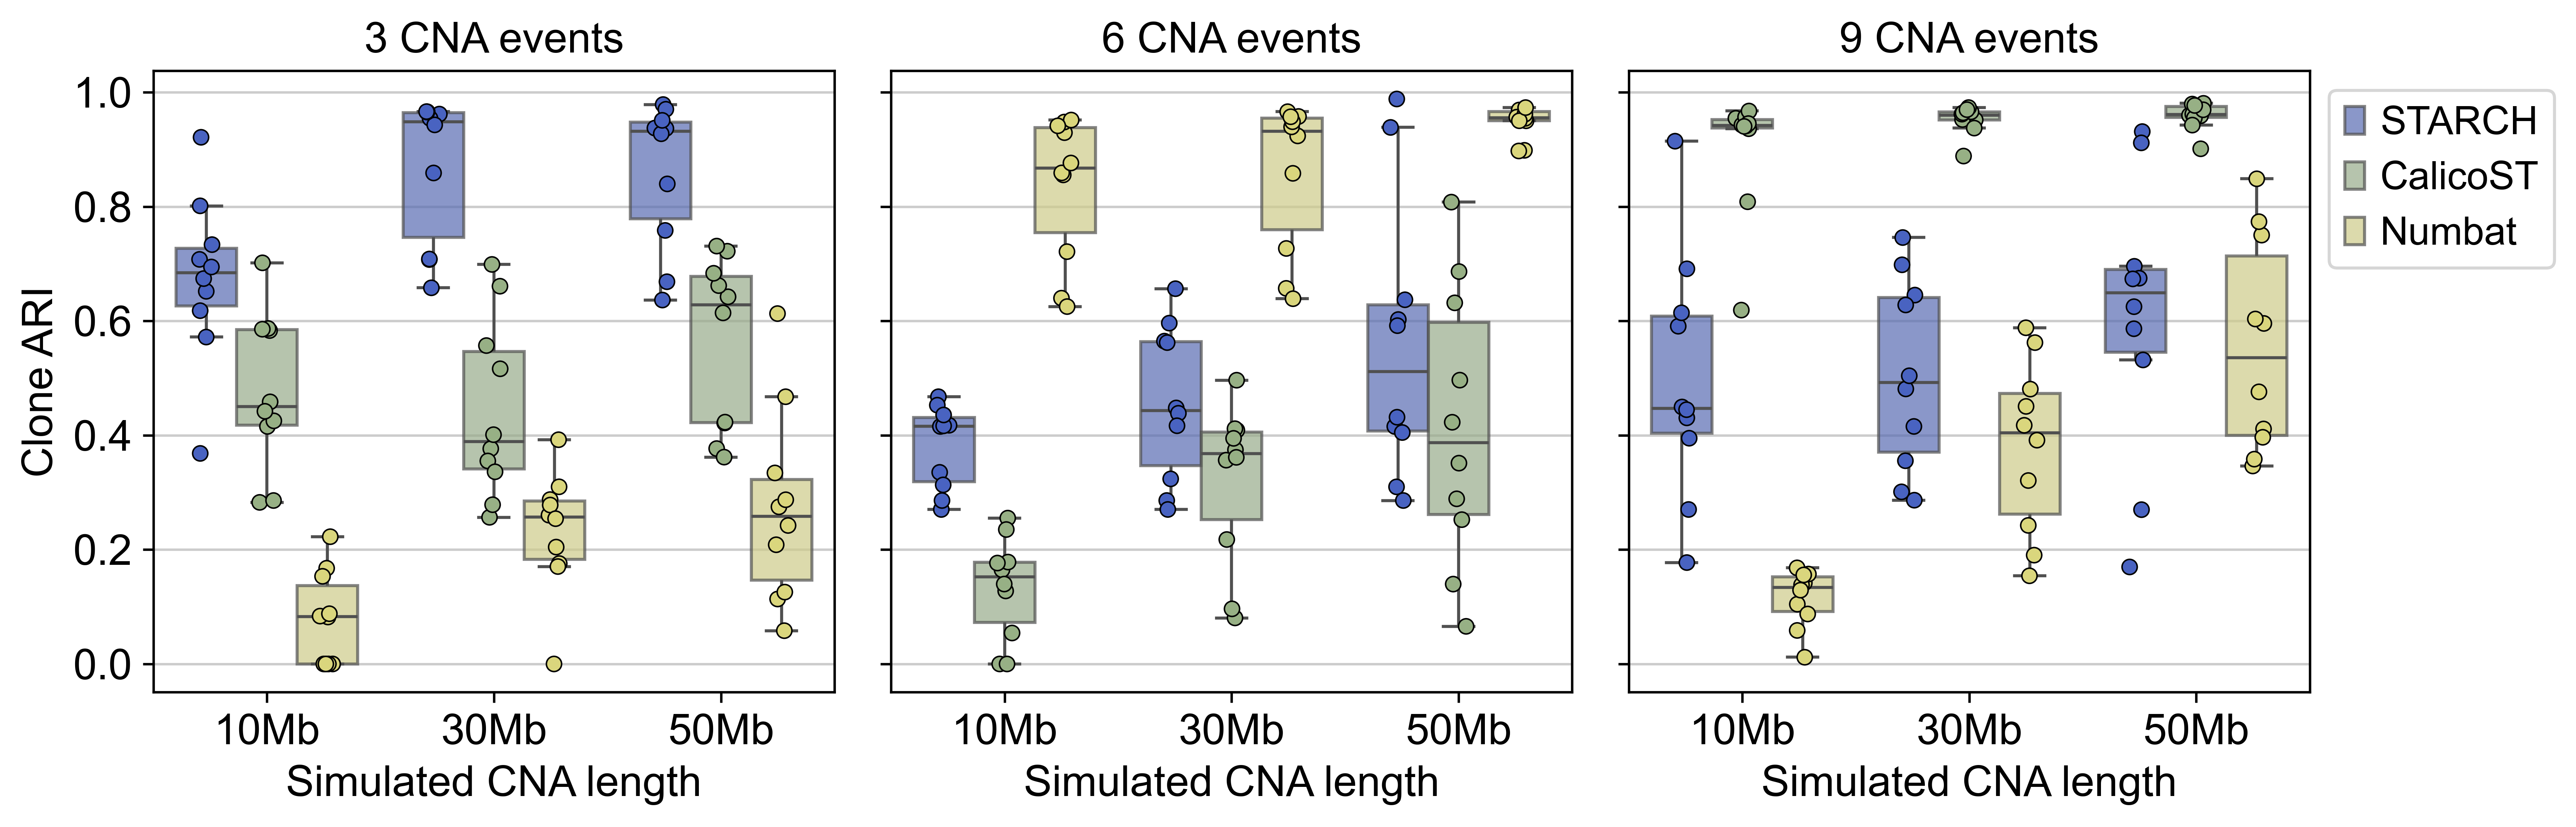

In [10]:
plot_aris(clone_aris)

# Event detection accuracy

The detection accuracy is evalated on a per-gene level:
the precision & sensitivity of genes involved in each category of event (Deletion, Amplication, LOH) for all events.

In [11]:
# NB (chr, start, end) for a given gene list.
df_hgtable = read_gene_loc(hg_table_file)
df_hgtable

,chr,start,end
name2,,,
FAM138A,1,34554,36081
OR4F5,1,65419,71585
AL627309.1,1,89295,133723
AL627309.3,1,89551,91105
AL627309.2,1,139790,140339
...,...,...,...
SHANK3,22,50674415,50733298
AC000036.1,22,50735825,50738139
ACR,22,50738196,50745339


In [12]:
def get_f1s():
    list_events = [
        "DEL",
        "AMP",
        "CNLOH",
        "overall"
    ]

    cna_sizes = ["1e7", "3e7", "5e7"]

    # EG 6 shared CNAs and 3 clone specific. 
    all_n_cnas = [ (1,2), (3,3), (6,3) ]
    df_event_f1 = []

    for n_cnas in all_n_cnas:
        for cna_size in cna_sizes:
            for ploidy in [2]:
                for random in np.arange(10):
                    sampleid = f"numcnas{n_cnas[0]}.{n_cnas[1]}_cnasize{cna_size}_ploidy{ploidy}_random{random}"
                
                    truth_cna_file = f"{true_dir}/{sampleid}/truth_cna.tsv"
                    
                    # NB 
                    true_gene_cna = read_true_gene_cna(df_hgtable, truth_cna_file)
                
                    # CalicoST
                    configuration_file = f"{calico_pure_dir}/{sampleid}/configfile0"
                    calico_gene_cna = read_calico_gene_cna(configuration_file)
                    
                    F1_dict = compute_gene_F1(
                        true_gene_cna,
                        calico_gene_cna
                    )

                    interim = pd.DataFrame({
                        "cnas": f"{n_cnas[0], n_cnas[1]}",
                        "n_cnas": n_cnas[0] + n_cnas[1],
                        "cna_size": cna_size,
                        "random": random,
                        "ploidy": int(ploidy),
                        "sample_id": sampleid,
                        "method": "CalicoST",
                        "event": list_events, 
                        "F1": [F1_dict[e] for e in list_events],
                        "true_cna": truth_cna_file,
                        "config": configuration_file,
                        }
                    )
                
                    df_event_f1.append(interim)
                    
                    # Numbat
                    bulk_clones_final_file = f'{numbat_dir}/{sampleid}/outs/bulk_clones_final.tsv.gz'
                
                    if Path(bulk_clones_final_file).exists():
                        numbat_gene_cna = read_numbat_gene_cna(bulk_clones_final_file)
                        
                        F1_dict = compute_gene_F1(true_gene_cna, numbat_gene_cna)
                    
                        df_event_f1.append(
                            pd.DataFrame({
                                "cnas": f"{n_cnas[0], n_cnas[1]}",
                                "n_cnas": n_cnas[0] + n_cnas[1],
                                "cna_size": cna_size,
                                "random": random,
                                "ploidy": int(ploidy),
                                "sample_id": sampleid,
                                "method": "Numbat",
                                "event": list_events,
                                "F1": [F1_dict[e] for e in list_events],
                                "true_cna": truth_cna_file,
                                }
                            )
                        )
                    else:
                        df_event_f1.append(
                            pd.DataFrame({
                                "cnas": f"{n_cnas[0], n_cnas[1]}",
                                 "n_cnas": n_cnas[0] + n_cnas[1],
                                 "cna_size": cna_size,
                                 "random": random,
                                 "ploidy": int(ploidy),
                                 "sample_id": sampleid,
                                 "method": "Numbat",
                                 "event": list_events,
                                 "F1": [0 for e in list_events],
                                 "true_cna": truth_cna_file,
                                }
                            )
                        )
                
                    # STARCH
                    states_file = f'{starch_dir}/{sampleid}/states_STITCH_output.csv'
                    
                    starch_gene_cna = read_starch_gene_cna(states_file)
                
                    F1_dict = compute_gene_F1(true_gene_cna, starch_gene_cna)
                
                    df_event_f1.append(
                        pd.DataFrame({
                            "cnas": f"{n_cnas[0], n_cnas[1]}",
                            "n_cnas": n_cnas[0] + n_cnas[1],
                            "cna_size": cna_size,
                            "random": random,
                            "ploidy": int(ploidy),
                            "sample_id": sampleid,
                            "method": "STARCH",
                            "event": list_events,
                            "F1": [F1_dict[e] for e in list_events],
                            "true_cna": truth_cna_file,
                            }
                        )
                    )

    return  pd.concat(df_event_f1, ignore_index=True)

In [21]:
df_event_f1 = get_f1s()
df_event_f1

,cnas,n_cnas,cna_size,random,ploidy,sample_id,method,event,F1,true_cna,config
0,"(1, 2)",3,1e7,0,2,numcnas1.2_cnasize1e7_ploidy2_random0,CalicoST,DEL,0.378378,../simulated_data_related//numcnas1.2_cnasize1...,../nomixing_calicost_related//numcnas1.2_cnasi...
1,"(1, 2)",3,1e7,0,2,numcnas1.2_cnasize1e7_ploidy2_random0,CalicoST,AMP,0.115756,../simulated_data_related//numcnas1.2_cnasize1...,../nomixing_calicost_related//numcnas1.2_cnasi...
2,"(1, 2)",3,1e7,0,2,numcnas1.2_cnasize1e7_ploidy2_random0,CalicoST,CNLOH,0.790698,../simulated_data_related//numcnas1.2_cnasize1...,../nomixing_calicost_related//numcnas1.2_cnasi...
3,"(1, 2)",3,1e7,0,2,numcnas1.2_cnasize1e7_ploidy2_random0,CalicoST,overall,0.219251,../simulated_data_related//numcnas1.2_cnasize1...,../nomixing_calicost_related//numcnas1.2_cnasi...
4,"(1, 2)",3,1e7,0,2,numcnas1.2_cnasize1e7_ploidy2_random0,Numbat,DEL,0.000000,../simulated_data_related//numcnas1.2_cnasize1...,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1075,"(6, 3)",9,5e7,9,2,numcnas6.3_cnasize5e7_ploidy2_random9,Numbat,overall,0.863992,../simulated_data_related//numcnas6.3_cnasize5...,NaN
1076,"(6, 3)",9,5e7,9,2,numcnas6.3_cnasize5e7_ploidy2_random9,STARCH,DEL,0.134228,../simulated_data_related//numcnas6.3_cnasize5...,NaN
1077,"(6, 3)",9,5e7,9,2,numcnas6.3_cnasize5e7_ploidy2_random9,STARCH,AMP,0.000000,../simulated_data_related//numcnas6.3_cnasize5...,NaN
1078,"(6, 3)",9,5e7,9,2,numcnas6.3_cnasize5e7_ploidy2_random9,STARCH,CNLOH,0.000000,../simulated_data_related//numcnas6.3_cnasize5...,NaN


In [22]:
def plot_f1s(df_event_f1):
    fig, axes = plt.subplots(1, 3, figsize=(12,4), dpi=300)
    
    color_methods = ["#4963C1", "#97b085", "#dad67d"]

    for i, n_cnas in enumerate([3, 6, 9]):
        tmpdf = df_event_f1[df_event_f1.n_cnas == n_cnas]
    
        seaborn.boxplot(
            data=tmpdf,
            x='event',
            y='F1',
            hue='method',
            palette=seaborn.color_palette(color_methods),
            boxprops=dict(alpha=.7),
            linewidth=1,
            showfliers = False,
            ax=axes[i]
        )
    
        seaborn.stripplot(
            data=tmpdf,
            x='event',
            y='F1',
            hue='method',
            palette=seaborn.color_palette(color_methods),
            dodge=10,
            edgecolor="black",
            linewidth=0.5,
            ax=axes[i]
        )
    
        if i + 1 < 3:
            axes[i].get_legend().remove()
        
        axes[i].set_ylabel("F1")
        axes[i].set_xlabel(None)
        axes[i].set_title(f"{n_cnas} CNA events")
        axes[i].set_xticklabels( axes[0].get_xticklabels(), rotation=90 )

    h,l = axes[-1].get_legend_handles_labels()
    axes[-1].legend(h[:3], l[:3], loc="upper left", bbox_to_anchor=(1,1))

    fig.tight_layout()
    fig.show()

/var/folders/15/7gbpxlls5gjdc4w7hm4j0nhw0000gn/T/ipykernel_27045/3299471516.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels( axes[0].get_xticklabels(), rotation=90 )
/var/folders/15/7gbpxlls5gjdc4w7hm4j0nhw0000gn/T/ipykernel_27045/3299471516.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels( axes[0].get_xticklabels(), rotation=90 )
/var/folders/15/7gbpxlls5gjdc4w7hm4j0nhw0000gn/T/ipykernel_27045/3299471516.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels( axes[0].get_xticklabels(), rotation=90 )
/var/folders/15/7gbpxlls5gjdc4w7hm4j0nhw0000gn/T/ipykernel_27045/3299471516.py:45: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.

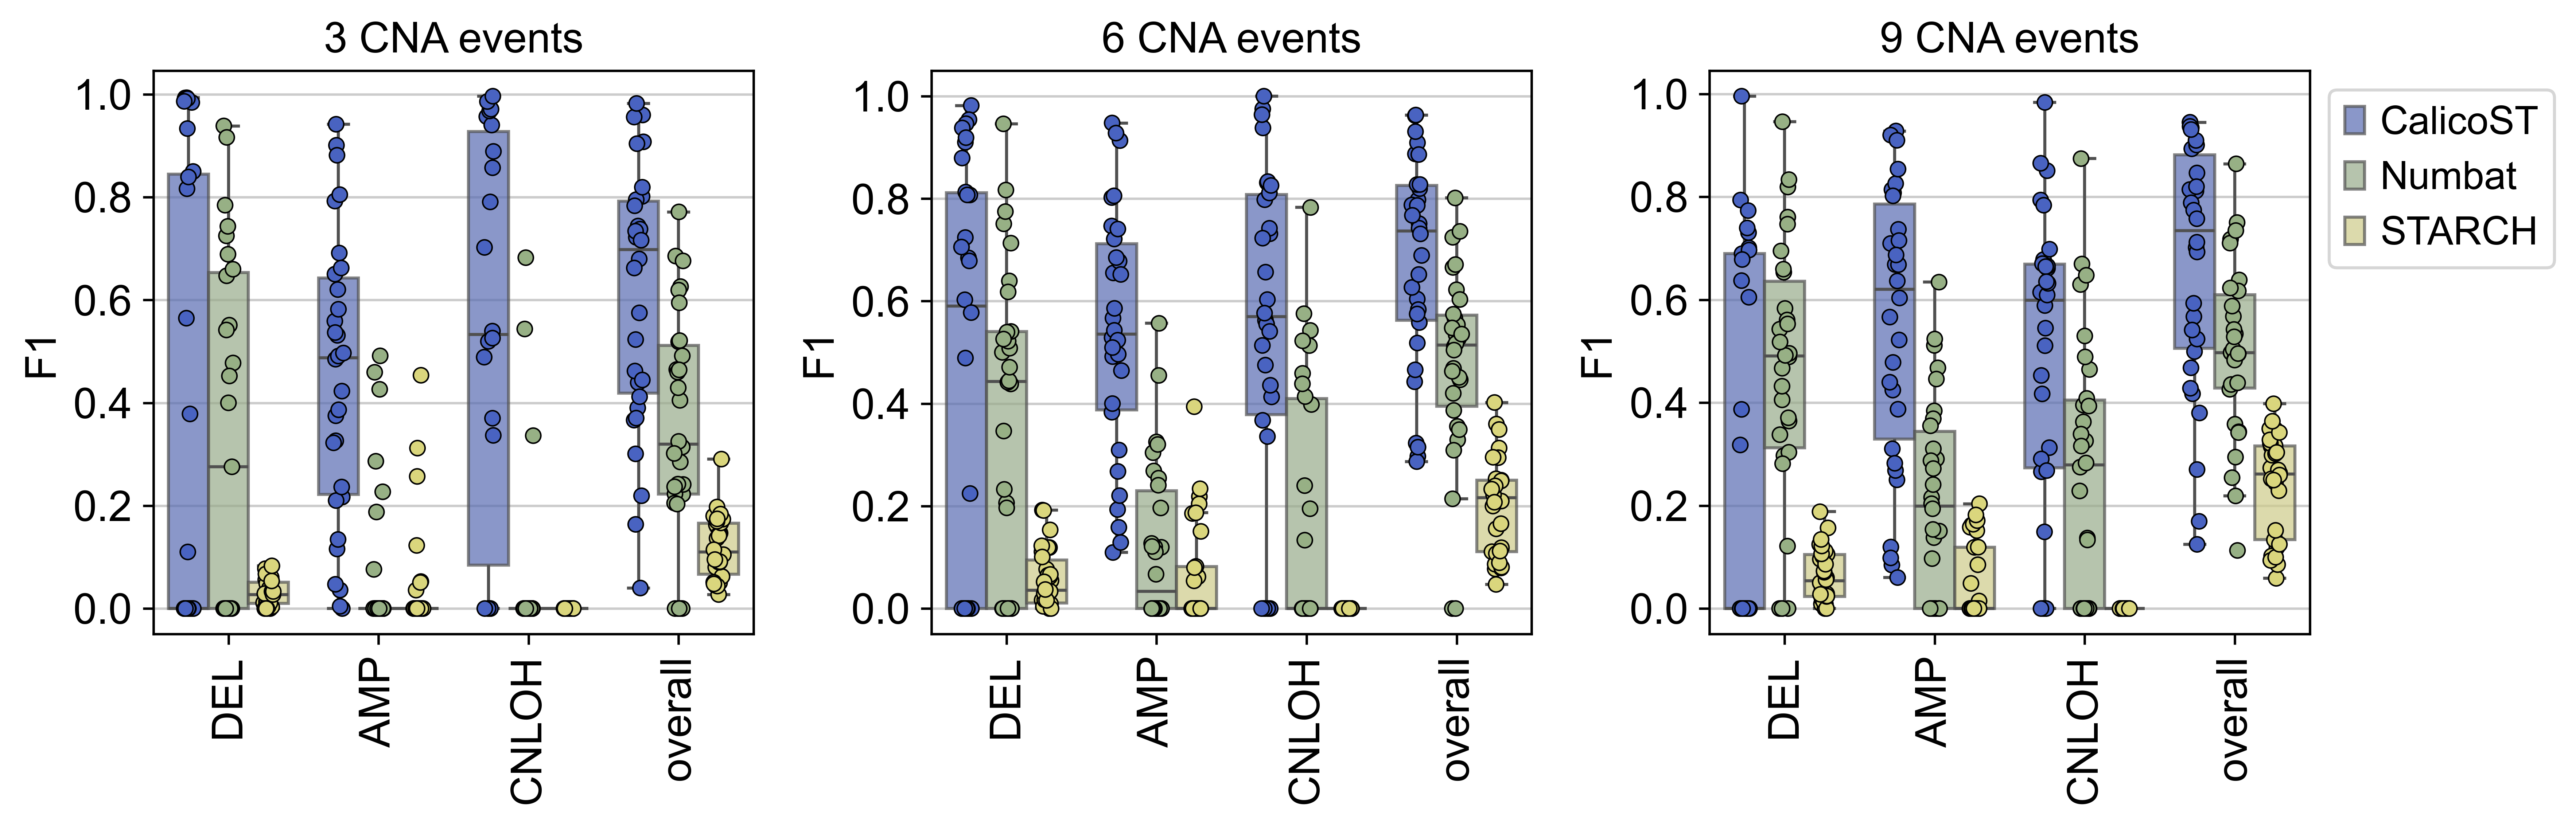

In [23]:
plot_f1s(df_event_f1)

# Done.